In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

def LoadComplexData(file,**genfromtext_args):
    """
    Load complex data in the C++ format in numpy.
    """
    array_as_strings = np.genfromtxt(file,dtype=str,**genfromtext_args)
    complex_parser = np.vectorize(lambda x: complex(*eval(x)))
    return complex_parser(array_as_strings)


In [3]:
time = np.genfromtxt('../data/results0034/time.dat')
afield = np.genfromtxt('../data/results0034/Afield_i.dat')
psi2 = np.genfromtxt('../data/results0034/init_psi2.dat')
psi2_end = np.genfromtxt('../data/results0034/end_psi2.dat')
acc = LoadComplexData('../data/results0034/acc.dat')
dipole = LoadComplexData('../data/results0034/dipole.dat')

mask = LoadComplexData('../data/results0034/imask.dat')

w0 = 0.057
period = 2*np.pi/w0
tmax = 14*period
Nt = time.shape[0]
t,dt = np.linspace(0,tmax,Nt,retstep=True)
dw = 2*np.pi/tmax
wmax = dw*(Nt)/2
w = np.arange(-wmax,wmax,dw)

efield = -1/137.04*np.gradient(afield, dt)


/Users/rodrigomh/Documents/TDSESolver/python/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


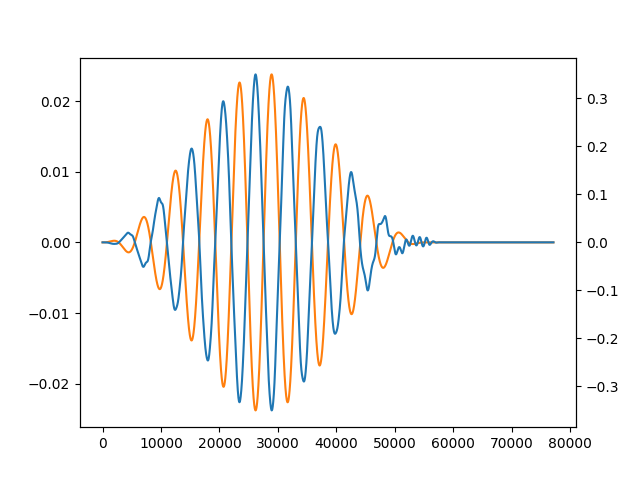

In [4]:
fig = plt.figure()
ax = fig.subplots(1,1)
# ax.plot(psi2)
ax.plot(efield,c='C1')
ax2 = ax.twinx()
ax2.plot(dipole)
#ax.set_yscale('log')

In [156]:
efieldF = np.fft.fft(efield)
efieldF = np.fft.fftshift(efieldF)
efieldF2 = np.abs(efieldF)**2

dipoleF = np.fft.fft(dipole)
dipoleF = np.fft.fftshift(dipoleF)
dipoleF2 = np.abs(dipoleF)**2

(0.0, 40.0)

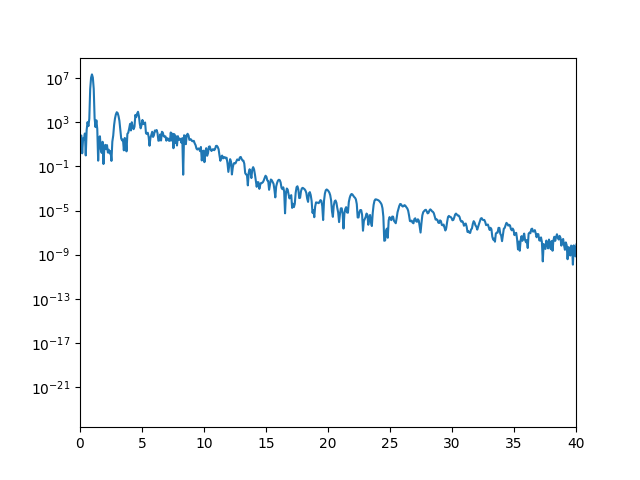

In [157]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.plot(w[:]/w0,dipoleF2)
ax.set_yscale('log')
ax.set_xlim(0,40)
#ax.set_ylim(1e-5,1e6)

In [6]:
def temp_window(t, tau,width):
    c = width/(2*np.sqrt(2*np.log(2)))
    return np.exp(-(t-tau)**2/(2*c**2))
    

(-1.1, 1.1)

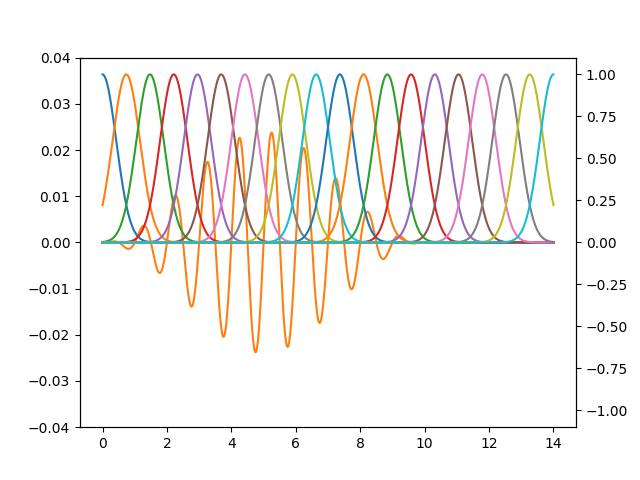

In [216]:
tau_array = np.linspace(0,tmax,20)


fig = plt.figure()
ax = fig.subplots(1,1)

wind = temp_window(t[:],0,2*period)
ax.plot(t[:]/period,efield,c='C1')
ax.set_ylim(-0.04,0.04)
ax2 = ax.twinx()
for i in tau_array:
    ax2.plot(t[:]/period,temp_window(t[:],i,period))

ax2.set_ylim(-1.1,1.1)


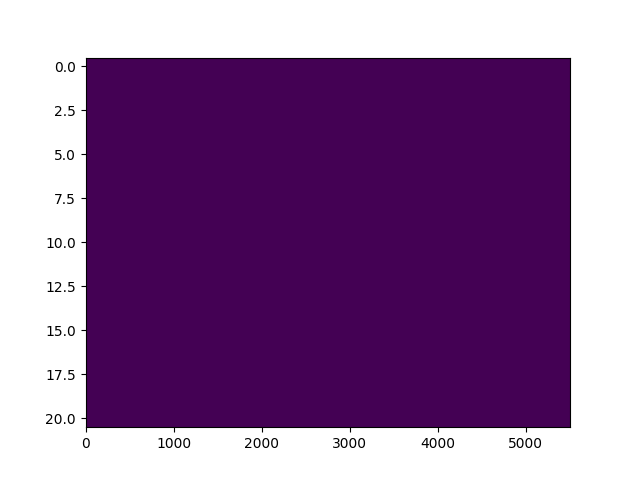

In [55]:
fft_size = np.int32(period/dt)
hop_size = np.int32(np.floor(fft_size*(1-0.5)))
pad_end_size = fft_size
total_segments = np.int32(np.ceil(efield.shape[0]/np.float32(hop_size)))
t_max = efield.shape[0]/(dw/(2*np.pi))

window = np.hanning(fft_size)  # our half cosine window
inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size
 
proc = np.concatenate((efield, np.zeros(pad_end_size)))              # the data to process
result = np.empty((total_segments, fft_size), dtype=np.complex128)    # space to hold the result
 
for i in range(total_segments):                      # for each segment
    current_hop = hop_size * i                        # figure out the current segment offset
    segment = proc[current_hop:current_hop+fft_size]  # get the current segment
    windowed = segment * window                       # multiply by the half cosine function
    padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
    spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
    result[i, :] = spectrum[:fft_size]               # append to the results array
fig = plt.figure()
ax = fig.subplots(1,1)
ax.imshow(np.abs(result)**2,aspect=200)

In [7]:
tau_step = 2*period
tau_size = int(tmax/tau_step/dt)
tau_array = np.linspace(0,tmax,200)
#TF = np.zeros(())
sin = np.sin(0.057*2*t[:Nt-1])
TFe = []
flast = 0.0
for j in range(int(len(tau_array))):
    wind = temp_window(t[:Nt],tau_array[j],tau_step)
    temp = np.fft.fft(wind*efield,)
    temp = np.fft.fftshift((temp))
    TFe.append(temp)
TFe = np.array(TFe)

TFd = []
flast = 0.0
for j in range(int(len(tau_array))):
    wind = temp_window(t[:Nt],tau_array[j],tau_step)
    temp = np.fft.fft(wind*dipole)
    temp = np.fft.fftshift((temp))
    TFd.append(temp)
TFd = np.array(TFd)

(0.0, 10.0)

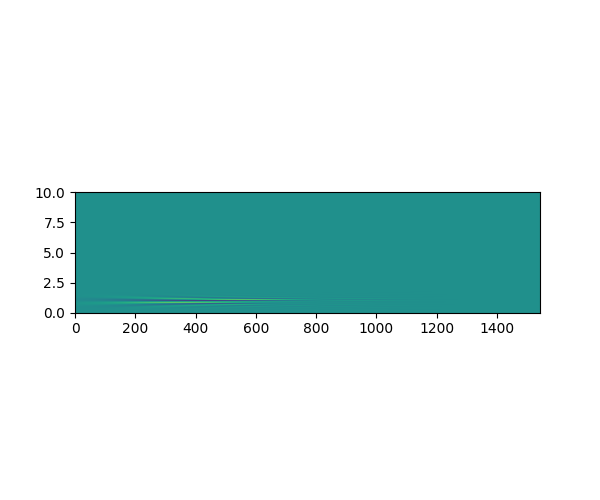

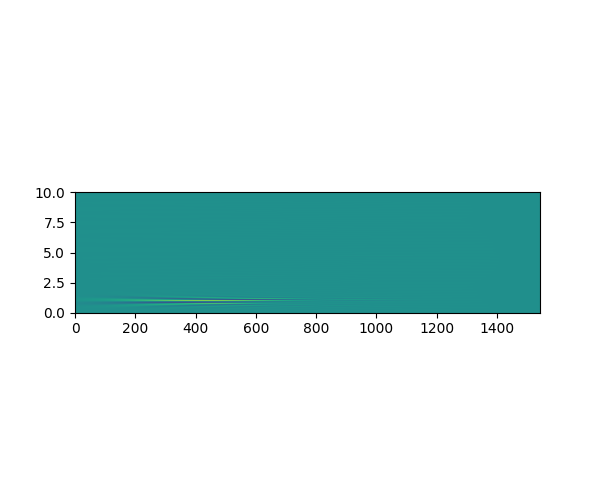

In [8]:
fig = plt.figure(figsize=(6,5))
ax = fig.subplots(1,1)
ax.imshow(TFe.real.T, extent=[t[0],t[-1],w[0]/w0,w[-1]/w0],aspect=40,interpolation='gaussian')
ax.set_ylim(0,10)
#ax.axhline(w[idx-1]/w0, color='white')
fig = plt.figure(figsize=(6,5))
ax = fig.subplots(1,1)
ax.imshow(TFd.real.T, extent=[t[0],t[-1],w[0]/w0,w[-1]/w0],aspect=40,interpolation='gaussian')
ax.set_ylim(0,10)

In [9]:
idx = np.argmin(np.abs(w-0.057))
w[idx]

0.05903571401739782

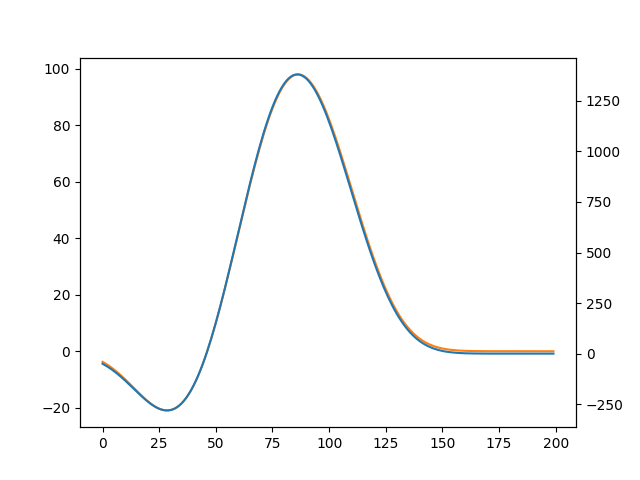

In [10]:
fig =plt.figure()
ax = fig.subplots(1,1)
ax.plot(TFe.imag[:,idx],color='C1')
ax2 = ax.twinx()
ax2.plot(-TFd.imag[:,idx])

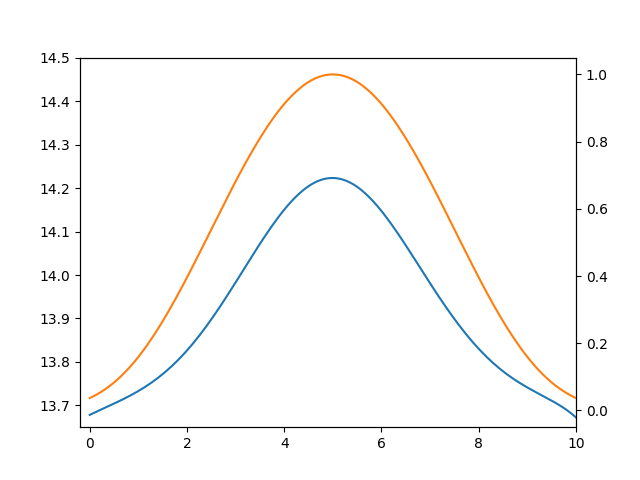

In [11]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.plot(tau_array/period,-(TFd[:,idx]/TFe[:,idx]).real)
ax.set_ylim(13.65,14.5)
ax.set_xlim(-0.2,10)
ax2 = ax.twinx()
ax2.plot(tau_array/period,np.abs(TFe[:,idx])/np.abs(TFe[:,idx]).max(),color='C1')

#ax2.plot(np.abs(TFe[:,idx])**2)


In [12]:
def sus(_dipole,_efield):
    tau_step = 2*period
    tau_array = np.linspace(0,tmax,200)
    #TF = np.zeros(())
    TFe = []
    flast = 0.0
    for j in range(int(len(tau_array))):
        wind = temp_window(t[:Nt],tau_array[j],tau_step)
        temp = np.fft.fft(wind*_efield)
        temp = np.fft.fftshift((temp))
        TFe.append(temp)
    TFe = np.array(TFe)

    TFd = []
    flast = 0.0
    for j in range(int(len(tau_array))):
        wind = temp_window(t[:Nt],tau_array[j],tau_step)
        temp = np.fft.fft(wind*_dipole)
        temp = np.fft.fftshift((temp))
        TFd.append(temp)
    TFd = np.array(TFd)
    idx = np.argmin(np.abs(w-0.057))

    return -(TFd[:,idx]/TFe[:,idx]).real

In [35]:
path = '../data/results'
suffix = ['0034','0037','0040','0044']
efield = [0.034,0.037,0.040,0.044]
inten = 3.51E16*np.array(efield)**2

data = []



for i in suffix:
    time = np.genfromtxt(path+i+'/time.dat')
    afield = np.genfromtxt(path+i+'/Afield_i.dat')
    dipole = LoadComplexData(path+i+'/dipole.dat')

    w0 = 0.057
    period = 2*np.pi/w0
    tmax = 14*period
    Nt = time.shape[0]
    t,dt = np.linspace(0,tmax,Nt,retstep=True)
    dw = 2*np.pi/tmax
    wmax = dw*(Nt)/2
    w = np.arange(-wmax,wmax,dw)

    efield = -1/137.04*np.gradient(afield, dt)
    
    
    tau_step = 2.5*period
    tau_array = np.linspace(0,tmax,200)
    #TF = np.zeros(())
    TFe = []
    for j in range(int(len(tau_array))):
        wind = temp_window(t[:Nt],tau_array[j],tau_step)
        temp = np.fft.fft(wind*efield,)
        temp = np.fft.fftshift((temp))
        TFe.append(temp)
    TFe = np.array(TFe)

    TFd = []
    for j in range(int(len(tau_array))):
        wind = temp_window(t[:Nt],tau_array[j],tau_step)
        temp = np.fft.fft(wind*dipole)
        temp = np.fft.fftshift((temp))
        TFd.append(temp)
    TFd = np.array(TFd)
    
    data.append(-(TFd[:,idx]/TFe[:,idx]).real)


Text(0.5, 0, 'Time (periods)')

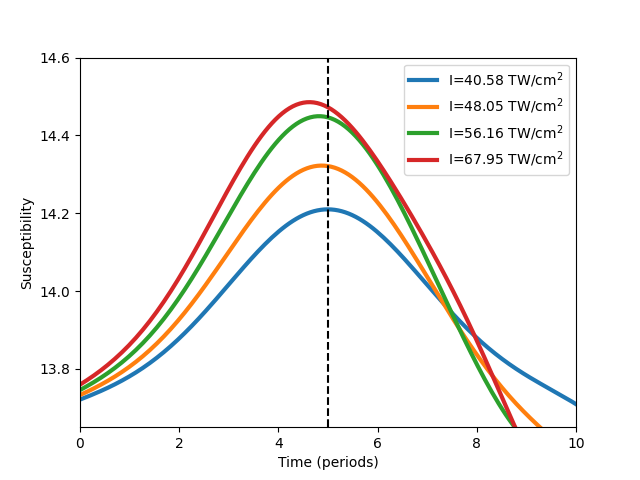

In [43]:
fig = plt.figure()
ax = fig.subplots(1,1)

for i,j in enumerate(data):
    ax.plot(tau_array/period, j,label=f'I=${np.round(inten[i]/1e12,2)}$ TW/cm$^2$',linewidth=3)
ax.legend(loc=0)
ax.set_ylim(13.65,14.6)
ax.axvline(5,color='k',linestyle='--')
ax.set_xlim(0,10)
ax.set_ylabel('Susceptibility')
ax.set_xlabel('Time (periods)')

(-0.1, 1.5)

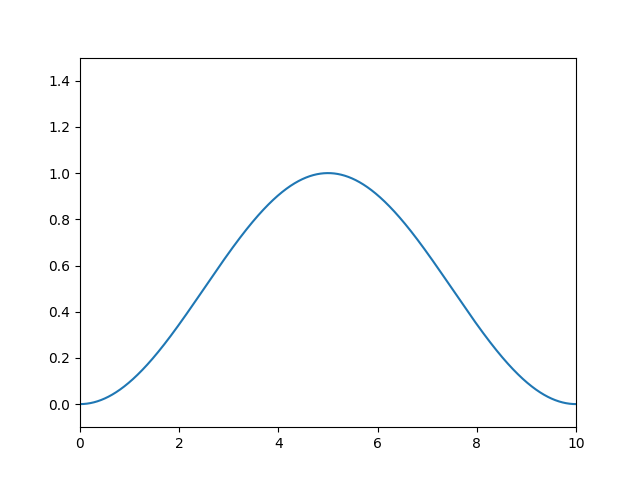

In [53]:
env = np.zeros(Nt)

for i,ti in enumerate(t):
    if ti<10*period:
        env[i] = np.sin(np.pi*ti/(10*period))**2
    else:
        break
fig = plt.figure()
ax = fig.subplots(1,1)
# ax.plot(psi2)
#ax.plot(t/period,efield,c='C1')
ax.plot(t/period,env)
ax.set_xlim(0,10)
ax.set_ylim(-0.1,1.5)